In [12]:
import os
import cv2 as cv
import numpy as np

from matplotlib import pyplot as plt

from scipy.spatial.distance import euclidean

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import random


In [188]:
clases = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [189]:
D = {}
for carpeta in os.listdir('BaseDatos/'):
    if carpeta in clases:
        D[carpeta] = []
        
        for nombreI in os.listdir('BaseDatos/' + carpeta):
            I = cv.imread('BaseDatos/' + carpeta + '/' + nombreI, 0)
            #if not np.isin(I, 0).all():
            D[carpeta].append(I)

In [195]:
for c in clases:
    print(c, len(D[c]))

angry 4930
disgust 543
fear 5083
happy 8987
neutral 6197
sad 6077
surprise 4002


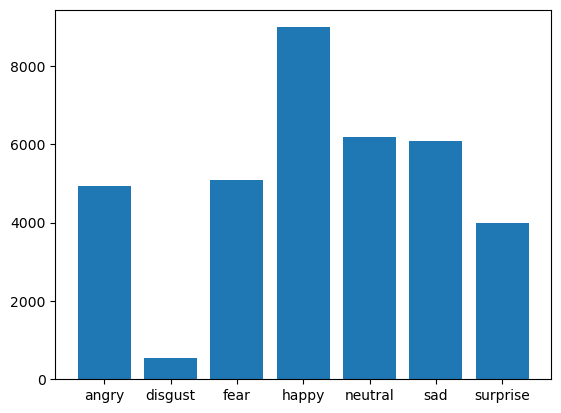

In [190]:
plt.bar(clases, [len(D[clase]) for clase in clases])
plt.show()

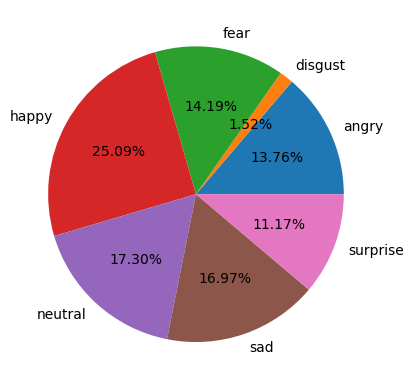

In [191]:
plt.pie([len(D[clase]) for clase in clases], labels= clases, autopct='%1.2f%%')
plt.show()

Como la data está desbalanceada, se deberá usar el "data augmentation" para tener misma cantidad de imágenes para cada clase.

### DATA AUGMENTATION

Objetivo: Obtener 4000 imágenes para cada clase

In [271]:
from keras.preprocessing.image import ImageDataGenerator

In [272]:
data_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [362]:
def upData(diccio, className, tam, dataGen):
    newList = []
    
    h = len(os.listdir('Dataset_Aug/' + className))
    
    while h < tam:
        
        randIndex = random.randint(0,len(diccio[className])-1)
        
        randImg = diccio[className][randIndex]
        
        #Convertir la imagen a la forma requerida por ImageDataGenerator
        
        randImg = randImg.reshape((1,) + randImg.shape + (1,))
        
        # Para generar las imágenes aleatorias:
        i = 0
        
        for batch in dataGen.flow(
            randImg,
            batch_size=1,
            save_to_dir='Dataset_Aug/' + className,
            save_prefix='Aug',
            save_format='png'):
        
            i+=1
            if i > 0:
                break
                
        h = len(os.listdir('Dataset_Aug/' + className))
        
        
        
    direcImges = os.listdir('Dataset_Aug/' + className)
        
    for dirI in direcImges:
        Imagen = cv.imread('Dataset_Aug/' + className + '/' + dirI, 0)
        newList.append(Imagen)
        
    return newList

In [363]:
newDisgustList = upData(D, 'disgust', 7000, data_gen)

In [364]:
len(newDisgustList)

7000

In [365]:
newFearList = upData(D, 'fear', 7000, data_gen)

In [366]:
len(newFearList)

7000

In [367]:
newNeutralList = upData(D, 'neutral', 7000, data_gen)

In [368]:
len(newNeutralList)

7000

In [369]:
newSadList = upData(D, 'sad', 7000, data_gen)

In [370]:
len(newSadList)

7000

In [371]:
newSurpriseList = upData(D, 'surprise',7000, data_gen)

In [372]:
len(newSurpriseList)

7000

In [373]:
newAngryList = upData(D, 'angry', 7000, data_gen)

In [374]:
len(newAngryList)

7000

In [375]:
def downData(diccio, className, tam):
    # Se deberán seleccionara aleatoriamente imágenes de la clase original
    
    newList = []
    histIndex = []
    
    randIndex = random.randint(0,len(diccio[className])-1)
        
    histIndex.append(randIndex)
    
    while len(newList)<tam:
        
        #Generando un index random:
        
        while randIndex in histIndex:
            randIndex = random.randint(0,len(diccio[className])-1)
        
        randImg = diccio[className][randIndex]
        
        histIndex.append(randIndex)
       
        newList.append(randImg)
                    
    return newList


In [378]:
newHappyList = downData(D, 'happy', 7000)

In [379]:
len(newHappyList)

7000

In [380]:
D_aug = {}

D_aug['angry'] = newAngryList
D_aug['disgust'] = newDisgustList
D_aug['fear'] = newFearList
D_aug['happy'] = newHappyList
D_aug['neutral'] = newNeutralList
D_aug['sad'] = newSadList
D_aug['surprise'] = newSurpriseList

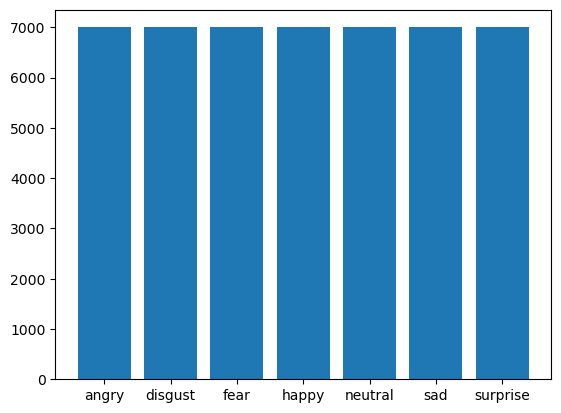

In [381]:
plt.bar(clases, [len(D_aug[clase]) for clase in clases])
plt.show()

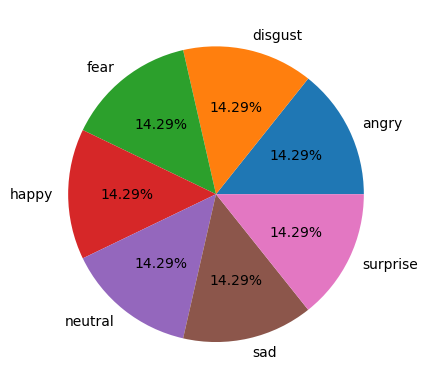

In [382]:
plt.pie([len(D_aug[clase]) for clase in clases], labels= clases, autopct='%1.2f%%')
plt.show()

### Extracción de características con SURF y SIFT

# SIFT

In [383]:
def miSIFT(I):
    sift = cv.xfeatures2d.SIFT_create()
    kp, FVs  = sift.detectAndCompute(I,None)
    return FVs

In [384]:
D_SIFT = {}
for clase in D_aug:
    D_SIFT[clase] = []
    for img in D_aug[clase]:
        FVs = miSIFT(img)
        if type(FVs) == np.ndarray:
            FV = np.mean(FVs, axis = 0)
            D_SIFT[clase].append(FV)
        else:
            D_SIFT[clase].append(np.zeros(128))

In [385]:
Angry_FV_SIFT = D_SIFT['angry']
Disgust_FV_SIFT = D_SIFT['disgust']
Fear_FV_SIFT = D_SIFT['fear']
Happy_FV_SIFT = D_SIFT['happy']
Neutral_FV_SIFT = D_SIFT['neutral']
Sad_FV_SIFT = D_SIFT['sad']
Surprise_FV_SIFT = D_SIFT['surprise']


In [386]:
type(Angry_FV_SIFT)

list

In [387]:
Angry_FV_SIFT = np.array(Angry_FV_SIFT)
Disgust_FV_SIFT = np.array(Disgust_FV_SIFT)
Fear_FV_SIFT = np.array(Fear_FV_SIFT)
Happy_FV_SIFT = np.array(Happy_FV_SIFT)
Neutral_FV_SIFT = np.array(Neutral_FV_SIFT)
Sad_FV_SIFT = np.array(Sad_FV_SIFT)
Surprise_FV_SIFT = np.array(Surprise_FV_SIFT)

In [388]:
listaGeneralSIFT = np.concatenate((Angry_FV_SIFT, Disgust_FV_SIFT, Fear_FV_SIFT, Happy_FV_SIFT, Neutral_FV_SIFT, Sad_FV_SIFT,Surprise_FV_SIFT),axis = 0)

# SURF

In [389]:
def miSURF(I):
    surf = cv.xfeatures2d.SURF_create(400)
    kp, des = surf.detectAndCompute(I, None)
    return des

In [390]:
D_SURF = {}
for clase in D_aug:
    D_SURF[clase] = []
    for img in D_aug[clase]:
        FVs = miSURF(img)
        if type(FVs) == np.ndarray:
            FV = np.mean(FVs, axis = 0)
            D_SURF[clase].append(FV)
        else:
            D_SURF[clase].append(np.zeros(64))

In [391]:
Angry_FV_SURF = D_SURF['angry']
Disgust_FV_SURF = D_SURF['disgust']
Fear_FV_SURF = D_SURF['fear']
Happy_FV_SURF = D_SURF['happy']
Neutral_FV_SURF = D_SURF['neutral']
Sad_FV_SURF = D_SURF['sad']
Surprise_FV_SURF = D_SURF['surprise']

In [392]:
Angry_FV_SURF = np.array(Angry_FV_SURF)
Disgust_FV_SURF = np.array(Disgust_FV_SURF)
Fear_FV_SURF = np.array(Fear_FV_SURF)
Happy_FV_SURF = np.array(Happy_FV_SURF)
Neutral_FV_SURF = np.array(Neutral_FV_SURF)
Sad_FV_SURF = np.array(Sad_FV_SURF)
Surprise_FV_SURF = np.array(Surprise_FV_SURF)

In [393]:
listaGeneralSURF = np.concatenate((Angry_FV_SURF, Disgust_FV_SURF, Fear_FV_SURF, Happy_FV_SURF, Neutral_FV_SURF, Sad_FV_SURF,Surprise_FV_SURF),axis = 0)

In [394]:
listaGeneralSURF.shape

(49000, 64)

   
    -Angry 0
    -Disgust 1
    -Fear 2
    -Happy 3
    -Neutral 4
    -Sad 5
    -Surprise 6

In [395]:
Y = np.concatenate((np.zeros(7000), np.ones(7000), np.full(7000,2), np.full(7000,3), np.full(7000,4), np.full(7000,5), np.full(7000,6)), axis = 0)

In [396]:
Y.shape

(49000,)

# Entrenando con ML

### SIFT

In [397]:
X_SIFT = listaGeneralSIFT

In [398]:
X_SIFT.shape

(49000, 128)

In [399]:
X_SIFT_train, X_SIFT_test, Y_SIFT_train, Y_SIFT_test = train_test_split(X_SIFT, Y, test_size=0.20, random_state=2022)

### SIFT + KNN

In [400]:
SIFT_KNN = KNeighborsClassifier()

In [401]:
SIFT_KNN.fit(X_SIFT_train, Y_SIFT_train)

KNeighborsClassifier()

In [402]:
res = SIFT_KNN.predict(X_SIFT_test) 

In [403]:
acc_SIFT_KNN = accuracy_score(Y_SIFT_test, res)

In [404]:
acc_SIFT_KNN

0.2926530612244898

In [316]:
matrixSIFT = confusion_matrix(Y_SIFT_test, res)

### SIFT + SVC

In [405]:
SIFT_SVC = SVC()

In [406]:
SIFT_SVC.fit(X_SIFT_train, Y_SIFT_train)

SVC()

In [407]:
res = SIFT_SVC.predict(X_SIFT_test)

In [408]:
acc_SIFT_SVC = accuracy_score(Y_SIFT_test, res)

In [409]:
acc_SIFT_SVC

0.29020408163265304

### SIFT + LR

In [410]:
SIFT_LR = LogisticRegression()

In [411]:
SIFT_LR.fit(X_SIFT_train, Y_SIFT_train)

C:\Users\kait__nh8vwsp\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [412]:
res = SIFT_LR.predict(X_SIFT_test)

In [413]:
acc_SIFT_LR = accuracy_score(Y_SIFT_test, res)

In [414]:
acc_SIFT_LR

0.25979591836734695

### SURF

In [415]:
X_SURF = listaGeneralSURF

In [416]:
X_SURF.shape

(49000, 64)

In [417]:
X_SURF_train, X_SURF_test, Y_SURF_train, Y_SURF_test = train_test_split(X_SURF, Y, test_size=0.10, random_state=2022)

### SURF + KNN

In [418]:
SURF_KNN = KNeighborsClassifier()

In [419]:
SURF_KNN.fit(X_SURF_train, Y_SURF_train)

KNeighborsClassifier()

In [420]:
res = SURF_KNN.predict(X_SURF_test) 

In [421]:
acc_SURF_KNN = accuracy_score(Y_SURF_test, res)

In [422]:
acc_SURF_KNN

0.20857142857142857

### SURF + SVC

In [423]:
SURF_SVC = SVC()

In [424]:
SURF_SVC.fit(X_SURF_train, Y_SURF_train)

SVC()

In [425]:
res = SURF_SVC.predict(X_SURF_test)

In [426]:
acc_SURF_SVC = accuracy_score(Y_SURF_test, res)

In [427]:
acc_SURF_SVC

0.2512244897959184

### SURF + LR

In [428]:
SURF_LR = LogisticRegression()

In [429]:
SURF_LR.fit(X_SURF_train, Y_SURF_train)

C:\Users\kait__nh8vwsp\anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [430]:
res = SURF_LR.predict(X_SURF_test)

In [431]:
acc_SURF_LR = accuracy_score(Y_SURF_test, res)

In [432]:
acc_SURF_LR

0.22591836734693876

# Resultados

In [433]:
Modelos_ML = ['KNN', 'SVC', 'LR', 'KNN', 'SVC', 'LR']
FV_extractor = ['SIFT', 'SIFT', 'SIFT', 'SURF', 'SURF', 'SURF']

acc_result = [acc_SIFT_KNN, acc_SIFT_SVC, acc_SIFT_LR, acc_SURF_KNN, acc_SURF_SVC, acc_SURF_LR]

In [434]:
D_resultados = {'FV extractor':FV_extractor, 'Modelo ML':Modelos_ML, 'Accuracy':acc_result}

In [435]:
df_Final = pd.DataFrame(D_resultados)

In [436]:
df_Final

,FV extractor,Modelo ML,Accuracy
0,SIFT,KNN,0.292653
1,SIFT,SVC,0.290204
2,SIFT,LR,0.259796
3,SURF,KNN,0.208571
4,SURF,SVC,0.251224
5,SURF,LR,0.225918
